In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
from collections import Counter
from scipy import stats
import math
import yaml

plt.rcParams['pdf.fonttype'] = 42  # For PDF: embed text as text, not paths
plt.rcParams['svg.fonttype'] = 'none'  # For SVG: embed text as text, not paths
plt.rcParams['font.family'] = 'Arial'

In [2]:
all_data = pd.read_csv("../../datasets/intermediate/all_data_w_folds.csv")
FIG_DIR = "../../figures/dataset"

In [3]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

mappings = load_config("../../datasets/final/hierarchical_label_set.yaml")

In [4]:
# For the sake of visualization we do not want hierarchical labels to appear in the same annotation
# So we get rid of "vesicles" or "cytoskeleton" if a more specific compartment is annotated
# This is especially important for computing stats about mulitlocalization

def delete_duplicate_vesicle_cytoskeleton(locs):
    locs = set(locs.split(";"))
    cytoskel_sub = {
        "actin-filaments",
        "intermediate-filaments",
        "microtubules",
        "centrosome"
    }
    vesicle_sub = {
        "lysosomes",
        "endosomes",
        "peroxisomes",
        "lipid-droplets"
    }
    if len(locs.intersection(cytoskel_sub)) != 0:
        locs = locs - {"cytoskeleton"}
    if len(locs.intersection(vesicle_sub)) != 0:
        locs = locs - {"vesicles"}
    
    return ";".join(list(locs))

for col in all_data.columns:
    if "level1" in col:
        all_data[col] = all_data[col].apply(
            lambda x: delete_duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
        )

In [5]:
def rename_columns(df):
    return df.rename(columns={col: col.split('_')[-1] for col in df.columns})

hpa = rename_columns(all_data[all_data.hpa][["hpa_level1", "hpa_level2", "hpa_level3"]])
opencell = rename_columns(all_data[all_data.opencell][["opencell_level1", "opencell_level2", "opencell_level3"]])
uniprot = rename_columns(all_data[all_data.uniprot][["uni_level1", "uni_level2", "uni_level3"]])

hpa_trainset = rename_columns(all_data[all_data.hpa_trainset][["hpa_level1", "hpa_level2", "hpa_level3"]])
uniprot_trainset = rename_columns(all_data[all_data.uniprot_trainset][["uni_level1", "uni_level2", "uni_level3"]])
hou_testset = rename_columns(all_data[all_data.hou_testset][["hou_level1", "hou_level2", "hou_level3"]])
combined_trainset = rename_columns(all_data[all_data.hpa_uniprot_combined_trainset][["combined_level1", "combined_level2", "combined_level3"]])
combinedhuman_trainset = rename_columns(all_data[all_data.hpa_uniprot_combined_human_trainset][["combinedhuman_level1", "combinedhuman_level2", "combinedhuman_level3"]])

In [6]:
#These are the true "Num Labels" per level
print(hou_testset.level1.str.count(";").mean() + 1)
print(hou_testset.level2.str.count(";").mean() + 1)
print(hou_testset.level3.str.count(";").mean() + 1)

1.3012585212375458
1.2658626114315679
1.259045621394861


In [7]:
datasets = {
    "HPA":hpa, 
    "OpenCell":opencell,
    "UniProt":uniprot,
    "HOU testset":hou_testset,
    "HPA trainset":hpa_trainset,
    "UniProt trainset":uniprot_trainset,
    "Combined trainset":combined_trainset,
    "Combined (human) trainset":combinedhuman_trainset
    }

deep_pallete = sns.color_palette(palette='deep')
bright_pallete = sns.color_palette(palette='bright')

palette = {
    "HPA": bright_pallete[0],
    "HPA trainset": bright_pallete[0],
    "OpenCell": bright_pallete[1],
    "UniProt": bright_pallete[2],
    "UniProt trainset": bright_pallete[2],
    "HOU testset": bright_pallete[3],
    "Combined trainset": bright_pallete[4],
    "Combined (human) trainset": bright_pallete[5]
}

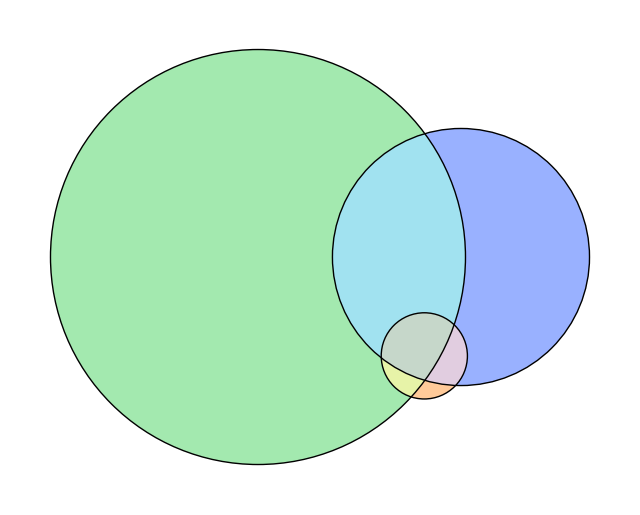

In [8]:
sns.set_theme(style="white")
hpa_keys = set(all_data.loc[all_data.hpa, "uniprot_id"].to_list())
opencell_keys = set(all_data.loc[all_data.opencell, "uniprot_id"].to_list())
uni_keys = set(all_data.loc[all_data.uniprot, "uniprot_id"].to_list())
hou_keys = set(all_data.loc[all_data.hou_testset, "uniprot_id"].to_list())

plt.figure(figsize=(8, 8))
v = venn3(
    subsets=[uni_keys, hpa_keys, opencell_keys], 
    set_labels=('', '', ''),
    set_colors=[palette["UniProt"],palette["HPA"],palette["OpenCell"]]
    )

c = venn3_circles(
    subsets=[uni_keys, hpa_keys, opencell_keys],
    linewidth=1,
    color="black"
    )

for idx, subset in enumerate(v.subset_labels):
    v.subset_labels[idx].set_visible(False)

plt.show()

In [9]:
def get_counts(df, order, col="level1", sep=";"):
    total = len(df)
    l = [s.split(sep) for s in df[col].to_list()]
    multilabel = [len(s) for s in l]
    l = sum(l, [])
    loc_counts = Counter(l)
    loc_counts = np.array([loc_counts[o] if o in loc_counts.keys() else 0 for o in order])

    multilabel_counts = Counter(multilabel)
    multilabel_counts = np.array([multilabel_counts[i] if i in multilabel_counts.keys() else 0 for i in range(1,9)])

    return loc_counts, loc_counts/total, multilabel_counts, multilabel_counts/total

cols = []
loc_dfs = []
multi_dfs = []
for dataset, df in datasets.items():
    print(dataset)
    for i in [1,2,3]:
        df_loc = pd.DataFrame(columns=["dataset", "level", "locations", "count", "frequency"])
        df_multi = pd.DataFrame(columns=["dataset", "level", "Num Labels", "count", "frequency"])
        order = mappings[f"level{i}"]
        loc_c, loc_f, multi_c, multi_f = get_counts(df, order, col=f"level{i}")
        
        df_loc["locations"] = order
        df_loc["count"] = loc_c
        df_loc["frequency"] = loc_f
        df_loc["dataset"] = dataset
        df_loc["level"] = i
        loc_dfs.append(df_loc)

        df_multi["Num Labels"] = [i for i in range(1,9)]
        df_multi["count"] = multi_c
        df_multi["frequency"] =  multi_f
        df_multi["dataset"] = dataset
        df_multi["level"] = i
        multi_dfs.append(df_multi)

loc_df = pd.concat(loc_dfs).reset_index(drop=True)
multi_df = pd.concat(multi_dfs).reset_index(drop=True)

HPA
OpenCell
UniProt
HOU testset
HPA trainset
UniProt trainset
Combined trainset
Combined (human) trainset


In [10]:
for i in [1,2,3]:

    row_order = mappings[f"level{i}"]
    col_order = ["HPA", "OpenCell", "UniProt", 
                "HOU testset", "HPA trainset", 
                "UniProt trainset", "Combined trainset", 
                "Combined (human) trainset"]
    t = loc_df[loc_df.level == i]
    t.loc[:, "value"] = t.apply(lambda x: str(x["count"]) + " (" + str(round(x["frequency"]*100, 2)) + "%)", axis=1)
    t = t.pivot(index='locations', columns='dataset', values="value").reindex(row_order)
    t = t[col_order]

    t.to_csv(f"{FIG_DIR}/level{i}_frequencies.csv", index=True)
    display(t)

/tmp/ipykernel_89854/718866581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.loc[:, "value"] = t.apply(lambda x: str(x["count"]) + " (" + str(round(x["frequency"]*100, 2)) + "%)", axis=1)


dataset,HPA,OpenCell,UniProt,HOU testset,HPA trainset,UniProt trainset,Combined trainset,Combined (human) trainset
locations,,,,,,,,
cytoskeleton,0 (0.0%),29 (2.22%),1025 (3.39%),7 (0.18%),0 (0.0%),714 (3.42%),699 (2.64%),91 (1.06%)
actin-filaments,366 (3.15%),0 (0.0%),761 (2.52%),29 (0.76%),268 (3.38%),427 (2.04%),603 (2.28%),257 (2.99%)
intermediate-filaments,147 (1.27%),0 (0.0%),0 (0.0%),6 (0.16%),121 (1.53%),0 (0.0%),87 (0.33%),87 (1.01%)
centrosome,572 (4.93%),50 (3.83%),575 (1.9%),125 (3.28%),360 (4.54%),258 (1.23%),525 (1.99%),399 (4.64%)
microtubules,254 (2.19%),0 (0.0%),990 (3.27%),39 (1.02%),177 (2.23%),538 (2.57%),650 (2.46%),278 (3.23%)
plasma-membrane,2181 (18.79%),135 (10.34%),6151 (20.33%),407 (10.67%),1496 (18.87%),4314 (20.64%),5240 (19.82%),1998 (23.25%)
cytosol,4829 (41.6%),483 (37.01%),11863 (39.22%),1291 (33.85%),3158 (39.84%),7495 (35.85%),9720 (36.77%),3325 (38.69%)
endoplasmic-reticulum,480 (4.14%),95 (7.28%),2453 (8.11%),166 (4.35%),276 (3.48%),1736 (8.3%),1863 (7.05%),496 (5.77%)
golgi-apparatus,1107 (9.54%),64 (4.9%),1489 (4.92%),145 (3.8%),802 (10.12%),972 (4.65%),1559 (5.9%),793 (9.23%)


/tmp/ipykernel_89854/718866581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.loc[:, "value"] = t.apply(lambda x: str(x["count"]) + " (" + str(round(x["frequency"]*100, 2)) + "%)", axis=1)


dataset,HPA,OpenCell,UniProt,HOU testset,HPA trainset,UniProt trainset,Combined trainset,Combined (human) trainset
locations,,,,,,,,
cytoskeleton,1284 (11.06%),79 (6.05%),2737 (9.05%),195 (5.11%),890 (11.23%),1661 (7.95%),2275 (8.61%),963 (11.21%)
plasma-membrane,2181 (18.79%),135 (10.34%),6151 (20.33%),407 (10.67%),1496 (18.87%),4314 (20.64%),5240 (19.82%),1998 (23.25%)
cytosol,4829 (41.6%),483 (37.01%),11863 (39.22%),1291 (33.85%),3158 (39.84%),7495 (35.85%),9720 (36.77%),3325 (38.69%)
endoplasmic-reticulum,480 (4.14%),95 (7.28%),2453 (8.11%),166 (4.35%),276 (3.48%),1736 (8.3%),1863 (7.05%),496 (5.77%)
golgi-apparatus,1107 (9.54%),64 (4.9%),1489 (4.92%),145 (3.8%),802 (10.12%),972 (4.65%),1559 (5.9%),793 (9.23%)
vesicles,2154 (18.56%),262 (20.08%),2971 (9.82%),384 (10.07%),1586 (20.01%),1850 (8.85%),2982 (11.28%),1514 (17.62%)
mitochondria,1029 (8.86%),11 (0.84%),3132 (10.35%),335 (8.78%),620 (7.82%),2173 (10.39%),2627 (9.94%),749 (8.72%)
nucleus,6451 (55.57%),479 (36.7%),11037 (36.49%),1709 (44.81%),4271 (53.88%),7000 (33.48%),10205 (38.6%),3880 (45.15%)
nucleoli,1393 (12.0%),98 (7.51%),955 (3.16%),196 (5.14%),892 (11.25%),521 (2.49%),1193 (4.51%),735 (8.55%)


/tmp/ipykernel_89854/718866581.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.loc[:, "value"] = t.apply(lambda x: str(x["count"]) + " (" + str(round(x["frequency"]*100, 2)) + "%)", axis=1)


dataset,HPA,OpenCell,UniProt,HOU testset,HPA trainset,UniProt trainset,Combined trainset,Combined (human) trainset
locations,,,,,,,,
cytoskeleton,1284 (11.06%),79 (6.05%),2737 (9.05%),195 (5.11%),890 (11.23%),1661 (7.95%),2275 (8.61%),963 (11.21%)
plasma-membrane,2181 (18.79%),135 (10.34%),6151 (20.33%),407 (10.67%),1496 (18.87%),4314 (20.64%),5240 (19.82%),1998 (23.25%)
cytosol,4829 (41.6%),483 (37.01%),11863 (39.22%),1291 (33.85%),3158 (39.84%),7495 (35.85%),9720 (36.77%),3325 (38.69%)
endomembrane-system,3374 (29.07%),376 (28.81%),6062 (20.04%),669 (17.54%),2413 (30.44%),4065 (19.44%),5737 (21.7%),2496 (29.04%)
mitochondria,1029 (8.86%),11 (0.84%),3132 (10.35%),335 (8.78%),620 (7.82%),2173 (10.39%),2627 (9.94%),749 (8.72%)
nucleus,6451 (55.57%),479 (36.7%),11037 (36.49%),1709 (44.81%),4271 (53.88%),7000 (33.48%),10205 (38.6%),3880 (45.15%)
nucleoli,1393 (12.0%),98 (7.51%),955 (3.16%),196 (5.14%),892 (11.25%),521 (2.49%),1193 (4.51%),735 (8.55%)
plastid,0 (0.0%),0 (0.0%),1160 (3.83%),0 (0.0%),0 (0.0%),1142 (5.46%),1142 (4.32%),0 (0.0%)


/tmp/ipykernel_89854/269069262.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='right', fontsize=10)
/tmp/ipykernel_89854/269069262.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)
/tmp/ipykernel_89854/269069262.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(["HOU test set", "HPA train set", "UniProt train set", "Combined\ntrain set", "Combined\n(human)\ntrain set"], rotation=60, ha='right', fontsize=10)
/tmp/ipykernel_89854/269069262.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])

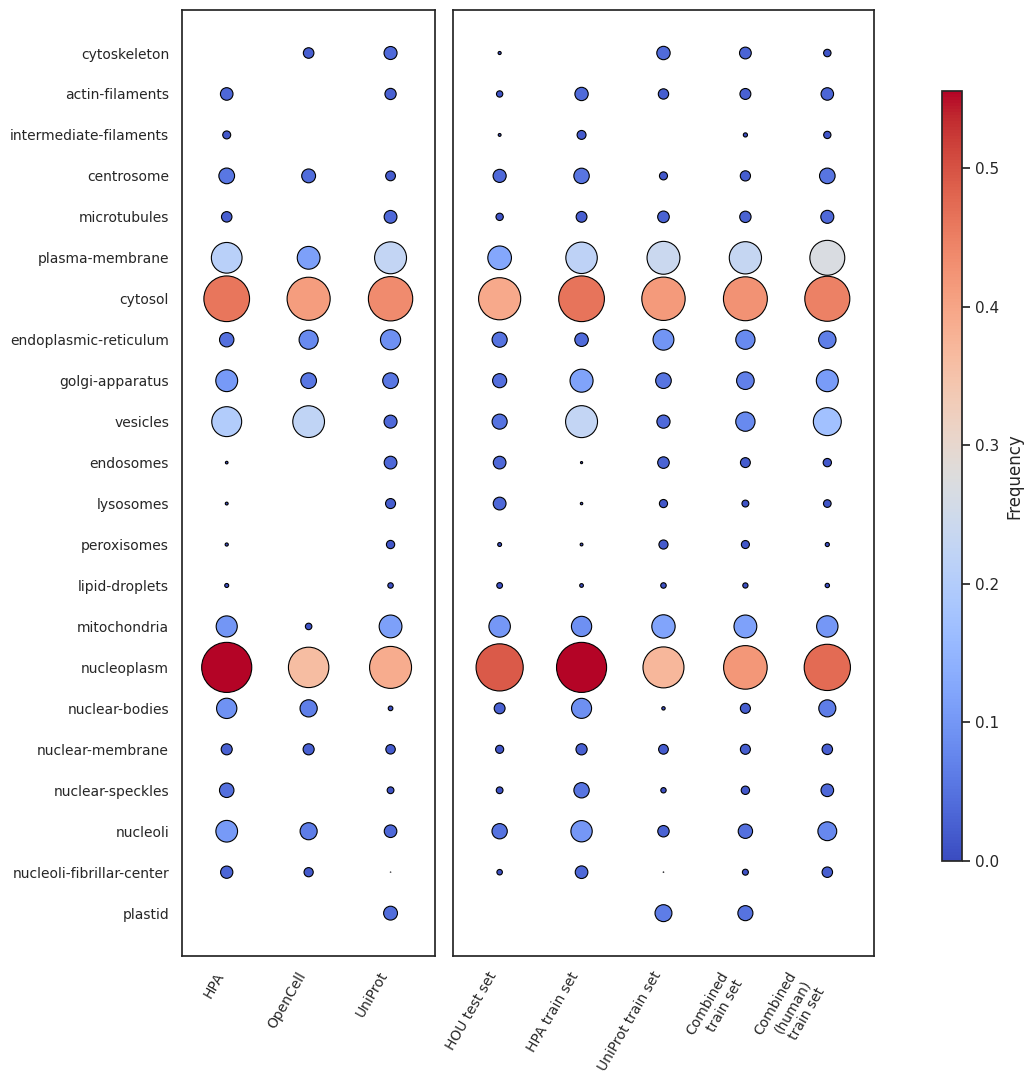

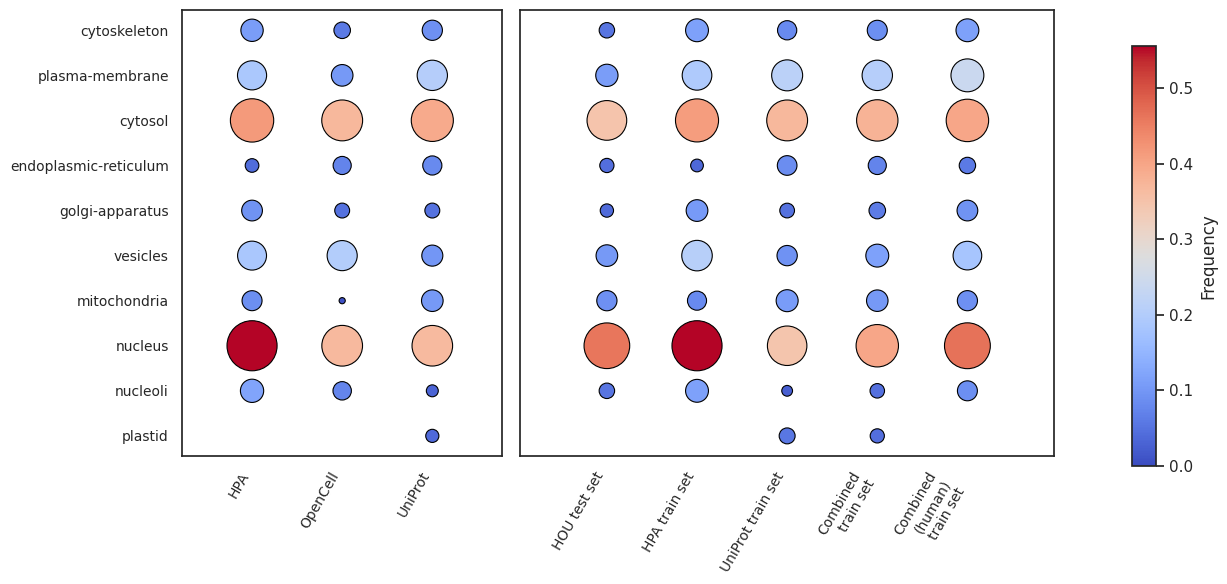

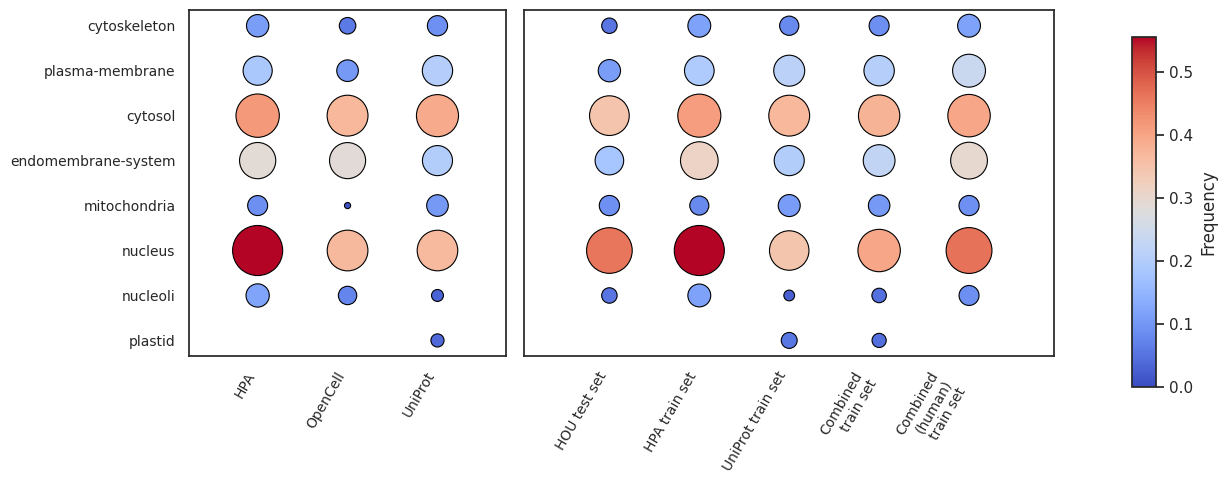

In [11]:
for i in [1,2,3]:
    if i == 1:
        figsize = (10, 11)
    elif i == 2:
        figsize = (12, 6)
    elif i == 3:
        figsize = (12, 5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [3, 5]}, sharey=True)

    # First plot
    sns.scatterplot(
        data=loc_df[(loc_df.dataset.isin(["HPA", "OpenCell", "UniProt"])) & (loc_df.level == i)], 
        x='dataset', 
        y='locations', 
        size='frequency', 
        sizes=(0, 1300), 
        hue='frequency',  # Color by frequency
        palette='coolwarm',  # Use a color palette
        legend=False,
        edgecolor='black',
        linewidth=0.8,
        ax=ax1
    )
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='right', fontsize=10)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=10)


    # Second plot
    scatter = sns.scatterplot(
        data=loc_df[(loc_df.dataset.isin(["HOU testset", "HPA trainset", "UniProt trainset", "Combined trainset", "Combined (human) trainset"])) & (loc_df.level == i)], 
        x='dataset', 
        y='locations', 
        size='frequency', 
        sizes=(0, 1300), 
        hue='frequency',  # Color by frequency
        palette='coolwarm',  # Use a color palette
        legend=False,
        edgecolor='black',
        linewidth=0.8,
        ax=ax2
    )
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xticklabels(["HOU test set", "HPA train set", "UniProt train set", "Combined\ntrain set", "Combined\n(human)\ntrain set"], rotation=60, ha='right', fontsize=10)


    # Add a color bar in the middle
    norm = plt.Normalize(loc_df['frequency'].min(), loc_df['frequency'].max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.95, 0.21, 0.02, 0.7])  # Adjust the position of the color bar
    fig.colorbar(sm, cax=cbar_ax, label='Frequency')

    # Adjust the aspect ratio to make the horizontal space smaller
    ax1.set_aspect(0.5, adjustable='datalim')
    ax2.set_aspect(0.5, adjustable='datalim')

    # Show the plot
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for the color bar

    plt.savefig(f"{FIG_DIR}/frequency_bubbleplot_level{i}.pdf", bbox_inches='tight', dpi=300)


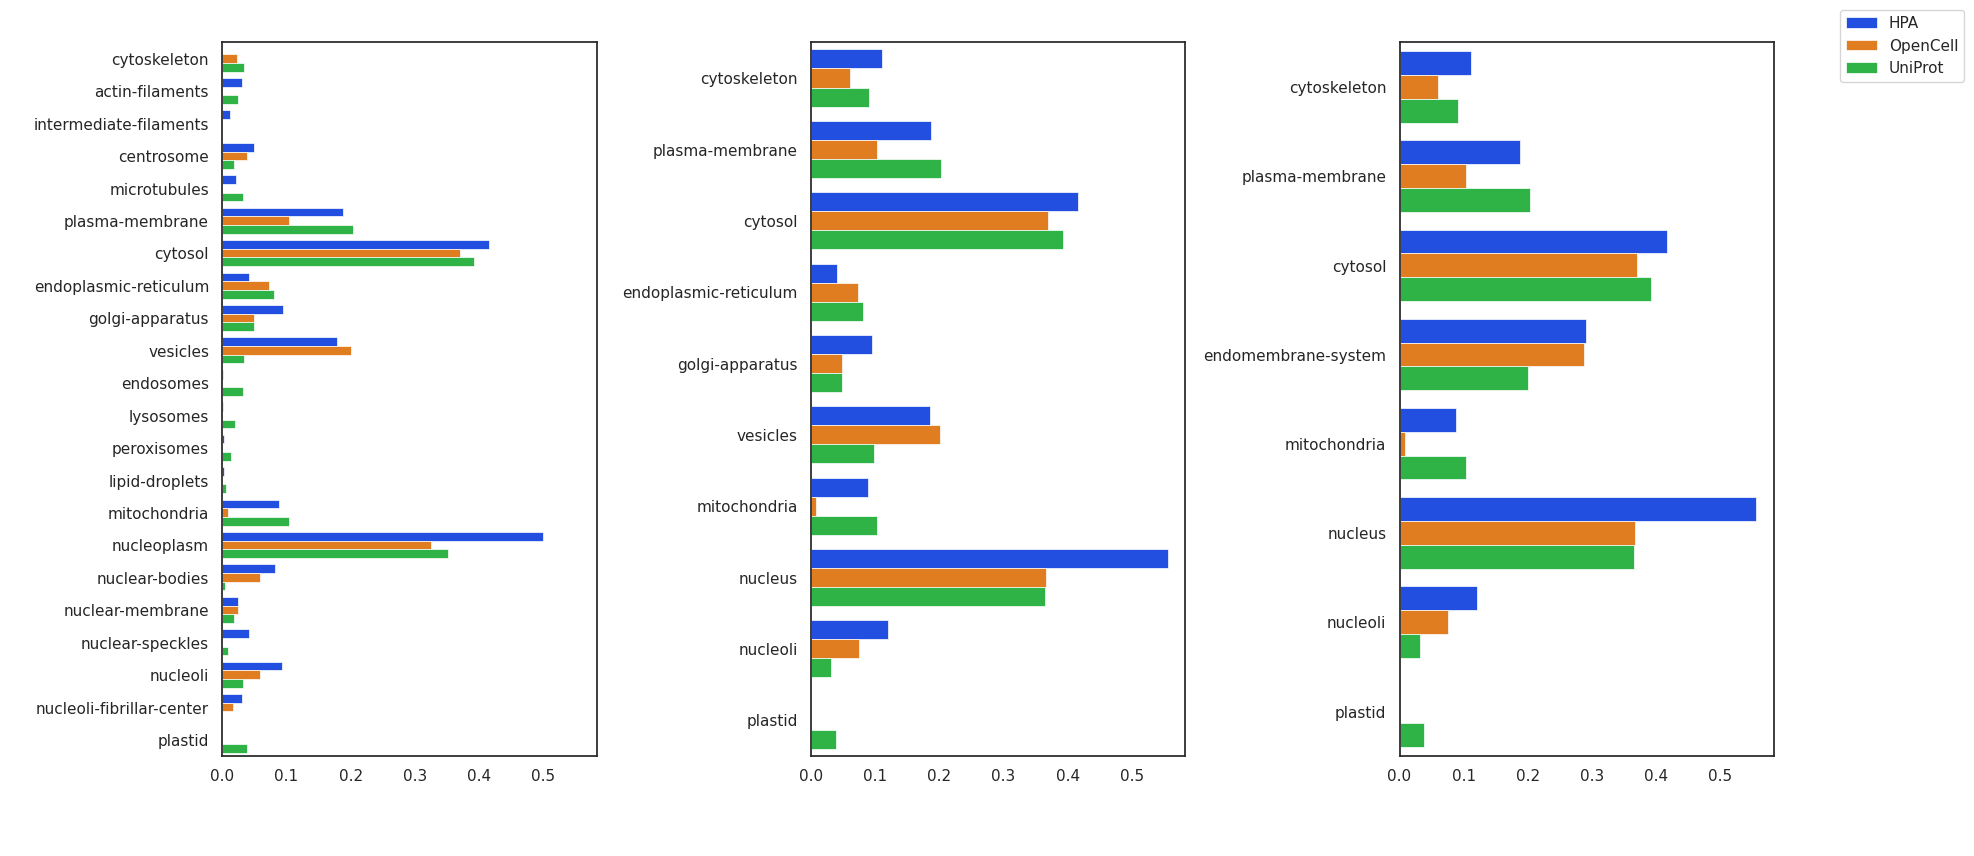

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)
for i, ax in enumerate(axes, start=1):
    df = loc_df[(loc_df.dataset.isin(["HPA", "OpenCell", "UniProt"])) & (loc_df.level == i)]
    sns.barplot(data=df, x="frequency", y="locations", hue="dataset", ax=ax, palette=palette, linewidth=0.5)  # Use the palette here
    ax.set_title(f"Level {i}", color='white')
    ax.set_xlabel("")  # Remove the "frequency" label on the x-axis
    ax.set_ylabel("")
    if i == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

# Add a single y-axis label on the leftmost plot
axes[0].set_ylabel("Locations", color='white')

# Add a single x-axis label below the entire plot
fig.text(0.5, -0.05, 'Frequency', ha='center', color='white')  # Adjust the y coordinate to move the label down

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout()

plt.savefig(f"{FIG_DIR}/raw_datasets_location_frequency.pdf",  bbox_inches='tight', dpi=300)
plt.show()



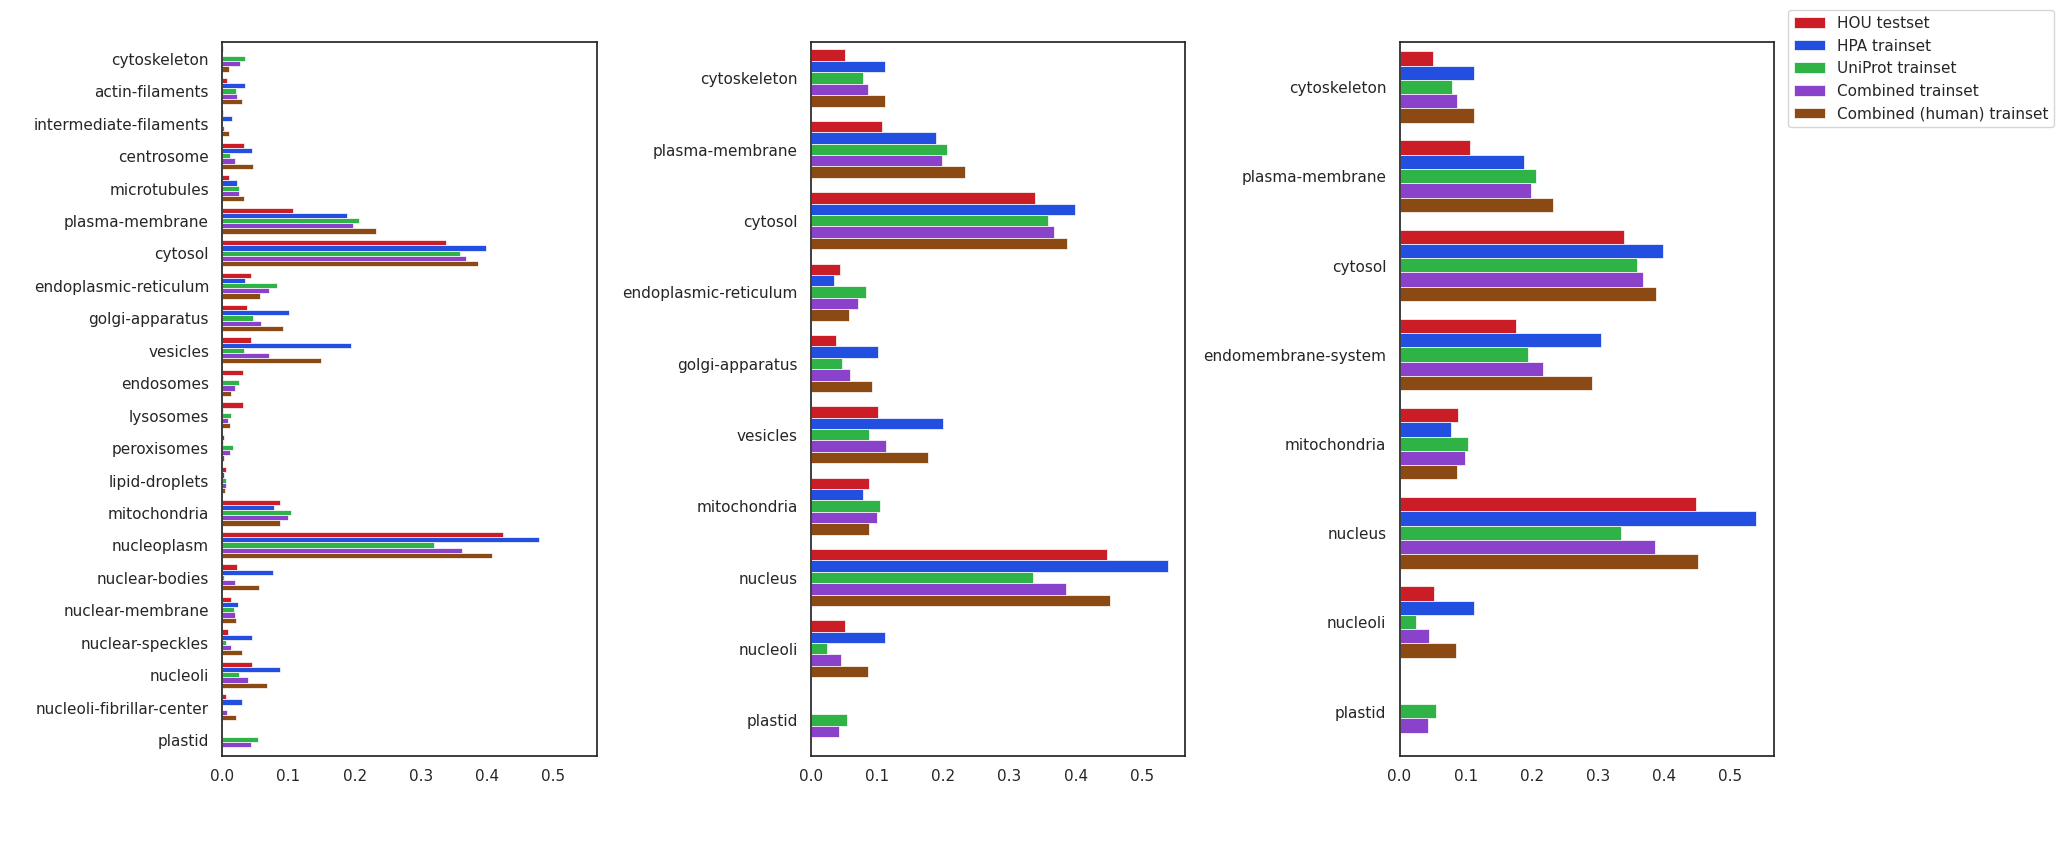

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)
for i, ax in enumerate(axes, start=1):
    df = loc_df[(loc_df.dataset.isin(["HPA trainset", "UniProt trainset", "Combined trainset", "Combined (human) trainset", "HOU testset"])) & (loc_df.level == i)]
    sns.barplot(data=df, x="frequency", y="locations", hue="dataset", ax=ax, palette=palette, linewidth=0.5)  # Use the palette here
    ax.set_title(f"Level {i}", color='white')
    ax.set_xlabel("")  # Remove the "frequency" label on the x-axis
    ax.set_ylabel("")
    if i == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

# Add a single y-axis label on the leftmost plot
axes[0].set_ylabel("Locations", color='white')

# Add a single x-axis label below the entire plot
fig.text(0.5, -0.05, 'Frequency', ha='center', color='white')  # Adjust the y coordinate to move the label down

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()

plt.savefig(f"{FIG_DIR}/our_datasets_location_frequency.pdf",  bbox_inches='tight', dpi=300)
plt.show()

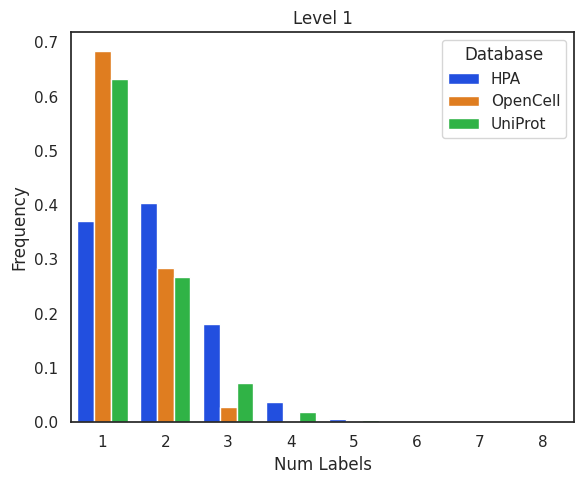

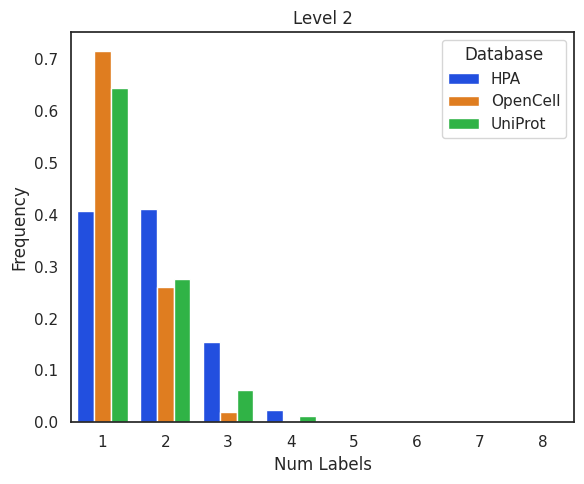

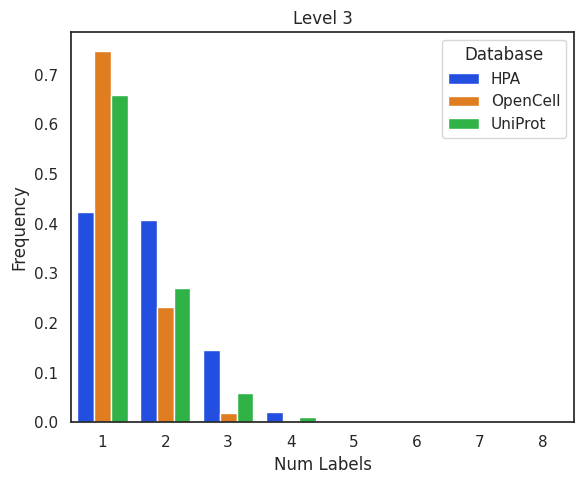

In [14]:
for level in [1,2,3]:
    f, ax = plt.subplots(figsize=(6, 5))
    df = multi_df[(multi_df.dataset.isin(["HPA", "OpenCell", "UniProt"])) & (multi_df.level==level)]
    multilabel_bar = sns.barplot(data=df, x="Num Labels", y="frequency", hue="dataset", ax=ax, palette=palette, errorbar=None)
    ax.set_ylabel("Frequency")
    plt.legend(title='Database', loc='upper right')
    ax.set_title(f"Level {level}")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/num_label_level{level}.pdf", dpi=300)
    plt.show()

In [15]:
temp = all_data[
    (all_data.hpa) & 
    (all_data.uniprot)
    ][["uniprot_id", "hpa_level1", "hpa_level2", "hpa_level3", "uni_level1", "uni_level2", "uni_level3"]]


def zip_zip(l1,l2):
    if len(l1) == 0 and len(l2) > 0:
        l = [("-", y) for y in l2]
    elif len(l1) > 0 and len(l2) == 0:  
        l = [(x, "-") for x in l1]
    elif len(l1) > 0 and len(l2) > 0:
        l = [(x,y) for x in l1 for y in l2]
    else: 
        l = []
    return l

for i in [1,2,3]:
    temp.loc[:, f"hpa_level{i}"] = temp[f"hpa_level{i}"].str.split(";").apply(lambda x: set(x))
    temp.loc[:, f"uni_level{i}"] = temp[f"uni_level{i}"].str.split(";").apply(lambda x: set(x))

    temp.loc[:, f"same_level{i}"] = temp.apply(lambda x: x[f"hpa_level{i}"].intersection(x[f"uni_level{i}"]), axis=1)

    temp.loc[:, f"hpa_not_uni_level{i}"] = temp[f"hpa_level{i}"] - temp[f"uni_level{i}"]
    temp.loc[:, f"uni_not_hpa_level{i}"] = temp[f"uni_level{i}"] - temp[f"hpa_level{i}"]

    temp.loc[:, f"replace_level{i}"] = temp.apply(
        lambda x: zip_zip(
            x[f"hpa_not_uni_level{i}"], 
            x[f"uni_not_hpa_level{i}"]), 
            axis=1)

    temp.loc[:, f"hpa_level{i}"] = temp[f"hpa_level{i}"].apply(lambda x: ";".join(x))
    temp.loc[:, f"uni_level{i}"] = temp[f"uni_level{i}"].apply(lambda x: ";".join(x))

/tmp/ipykernel_89854/2860228774.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar


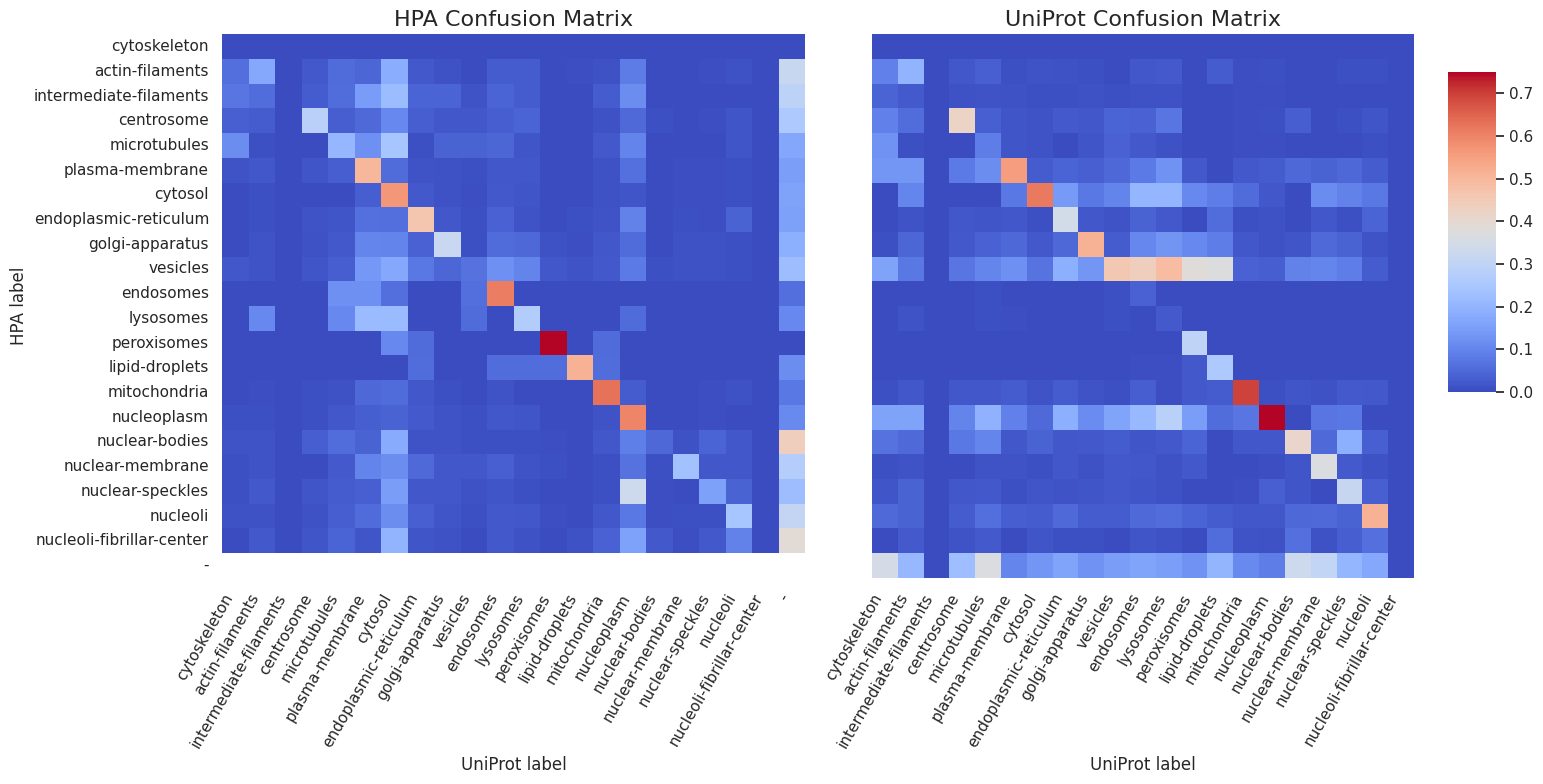

/tmp/ipykernel_89854/2860228774.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar


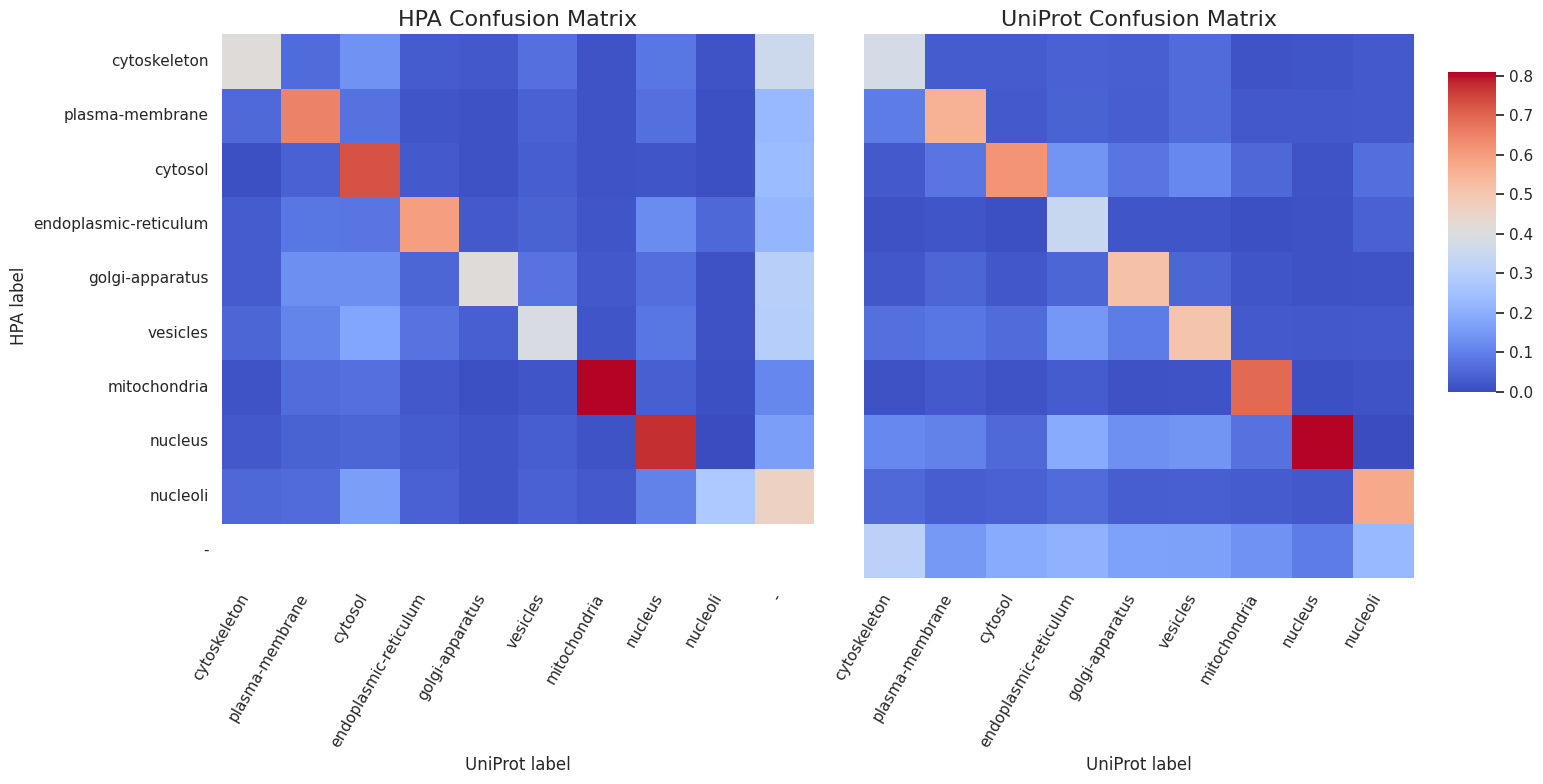

/tmp/ipykernel_89854/2860228774.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar


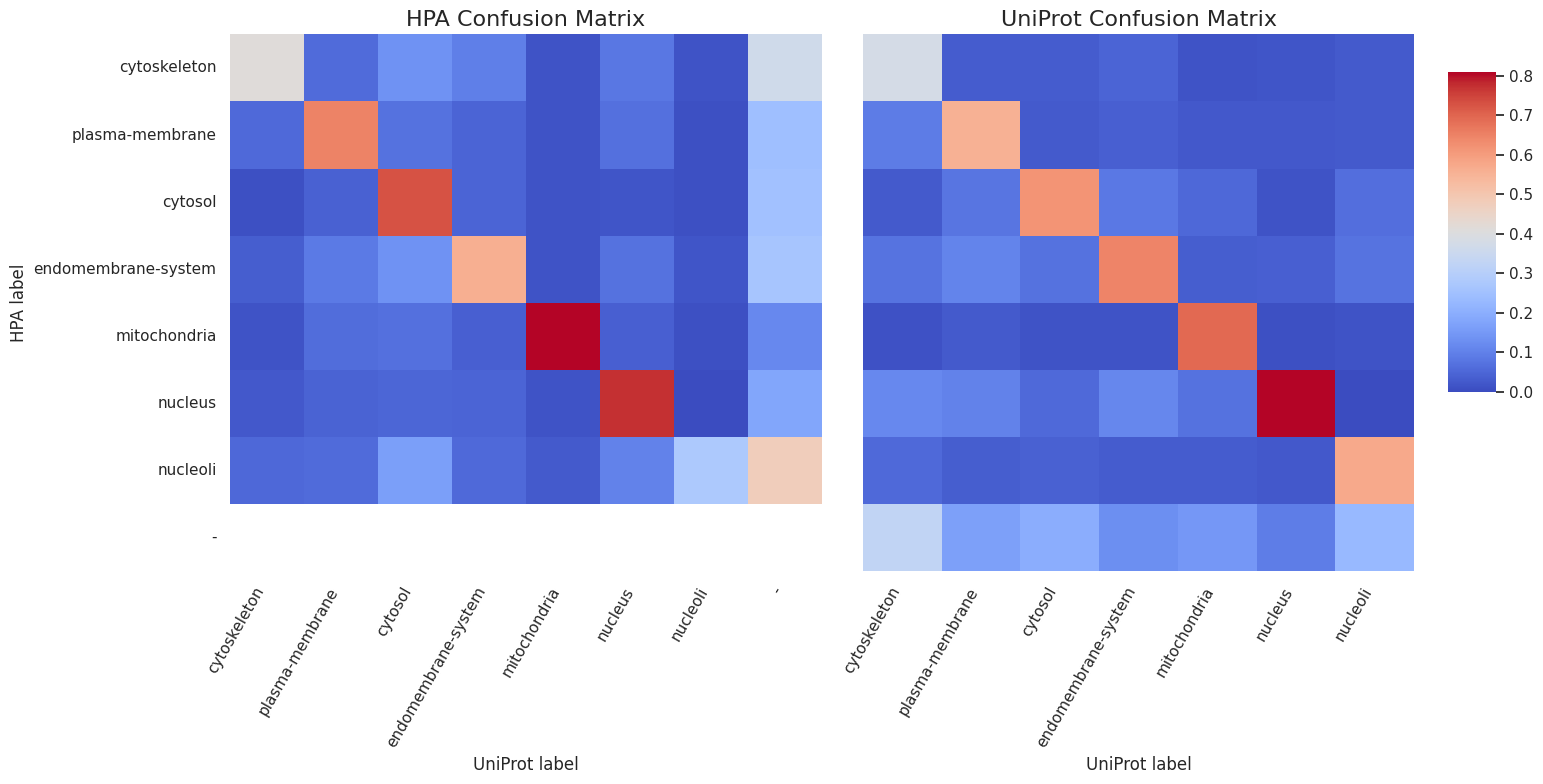

In [16]:
small_value = 1e-6
for i in [1,2,3]:
    order = mappings[f"level{i}"]
    order = order[:-1] #get rid of "plastid"

    hpa_counts, _, _, _ = get_counts(temp, order, col=f"hpa_level{i}", sep=";")
    hpa_counts = np.array(hpa_counts, dtype=np.float64)
    idx = np.where(hpa_counts==0)[0]
    hpa_counts[idx] += small_value
    uni_counts, _, _, _ = get_counts(temp, order, col=f"uni_level{i}", sep=";")
    uni_counts = np.array(uni_counts, dtype=np.float64)
    idx = np.where(uni_counts==0)[0]
    uni_counts[idx] = small_value

    order = order + ["-"]


    replacement_counter = np.zeros((len(order), len(order)))
    for row in temp[f"replace_level{i}"].to_list():
        for replacement in row:
            hpa_loc, uni_loc = replacement
            j = order.index(hpa_loc)
            k = order.index(uni_loc)
            replacement_counter[j,k] += 1

    for row in temp[f"same_level{i}"].to_list():
        for loc in row:
            j = order.index(loc)
            replacement_counter[j,j] += 1


    hpa_replacement_counter = replacement_counter[:-1, :]/hpa_counts[:, None]
    uni_replacement_counter = replacement_counter[:, :-1]/uni_counts[None, :]

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(16, 8), sharey=True, gridspec_kw={'width_ratios': [1, 0.93]})
    cbar_ax = fig.add_axes([.91, .5, .03, .4])  # Position for the color bar

    sns.heatmap(
        hpa_replacement_counter, 
        xticklabels=order, 
        yticklabels=order[:-1], 
        ax=ax1, 
        cmap="coolwarm", 
        cbar_ax=cbar_ax
        )
    ax1.set_xlabel("UniProt label")
    ax1.set_ylabel("HPA label")
    ax1.set_title("HPA Confusion Matrix", fontsize=16)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=60, ha='right')

    sns.heatmap(
        uni_replacement_counter, 
        xticklabels=order[:-1], 
        yticklabels=order, 
        ax=ax2, 
        cmap="coolwarm", 
        cbar_ax=cbar_ax,
        )
    ax2.set_xlabel("UniProt label")
    ax1.set_ylabel("HPA label")
    ax2.set_title("UniProt Confusion Matrix", fontsize=16)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=60, ha='right')

    plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar
    plt.savefig(f"{FIG_DIR}/confusion_matrices_level{i}.pdf", dpi=300)
    plt.show()


In [17]:
metrics = []
jaccard_distr = []

for i in [1,2,3]:
    if type(temp.iloc[0][f"hpa_level{i}"]) == str:
        temp.loc[:, f"hpa_level{i}"] = temp[f"hpa_level{i}"].str.split(";").apply(lambda x: set(x))
        temp.loc[:, f"uni_level{i}"] = temp[f"uni_level{i}"].str.split(";").apply(lambda x: set(x))

    equality = (temp[f"hpa_level{i}"] == temp[f"uni_level{i}"]).mean()
    overlap = temp.apply(lambda x: len(x[f"same_level{i}"]) > 0, axis=1).mean()
    jaccard_values = temp.apply(lambda x: len(x[f"same_level{i}"])/len(x[f"hpa_level{i}"].union(x[f"uni_level{i}"])), axis=1).to_numpy()
    jaccard_distr.append(jaccard_values)
    jaccard = jaccard_values.mean()
    set_inclusion = temp.apply(
        lambda x: x[f"uni_level{i}"].issubset(x[f"hpa_level{i}"]) or x[f"hpa_level{i}"].issubset(x[f"uni_level{i}"]) ,
        axis=1).mean()
    
    metrics.append([i, equality, overlap, jaccard, set_inclusion])
overlap_metrics = pd.DataFrame(metrics, columns=["level", "equality", "overlap", "jaccard", "set-inclusion"])

display(overlap_metrics)
overlap_metrics.to_csv(f"{FIG_DIR}/overlap_metrics.csv", index=False)

jaccard_distr = np.stack(jaccard_distr)

,level,equality,overlap,jaccard,set-inclusion
0,1,0.182731,0.816701,0.447815,0.631130
1,2,0.242568,0.873888,0.521535,0.732248
2,3,0.262640,0.889604,0.545167,0.763113


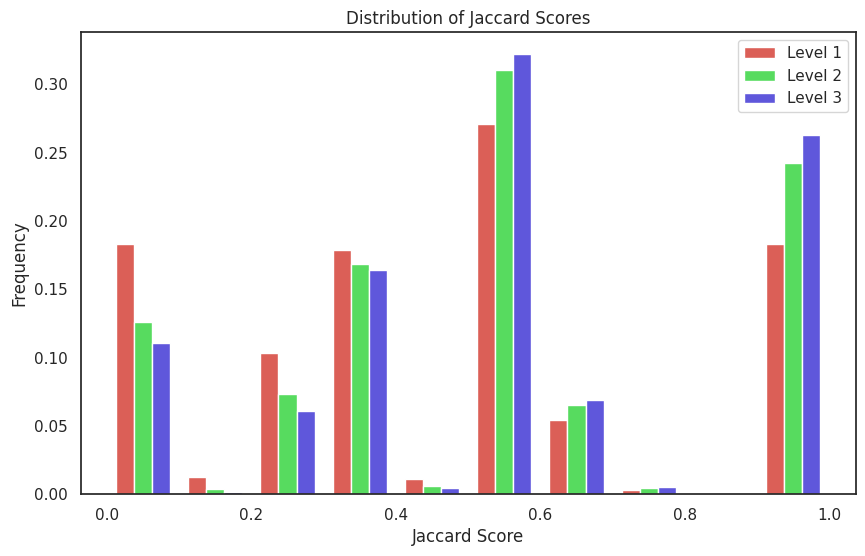

In [18]:
colors = sns.color_palette("hls", 3)

# Create a histogram for each level
plt.figure(figsize=(10, 6))
bin_edges = np.histogram_bin_edges(np.concatenate(jaccard_distr), bins=10)

for i, level in enumerate([1, 2, 3]):
    data = jaccard_distr[i]
    hist, bins = np.histogram(data, bins=bin_edges, density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    hist = hist / len(data)
    bar_width = (bin_edges[1] - bin_edges[0]) / 4  # Adjust the width of the bars

    plt.bar(bin_centers + i * bar_width - bar_width, hist, width=bar_width, label=f'Level {level}', color=colors[i])

# Add labels and title
plt.xlabel('Jaccard Score')
plt.ylabel('Frequency')
plt.title('Distribution of Jaccard Scores')
plt.legend()

plt.savefig(f"{FIG_DIR}/jacard_distr_by_level.pdf", dpi=300)
plt.show()

/home/groups/emmalu/zwefers/envs/seq2locenv/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


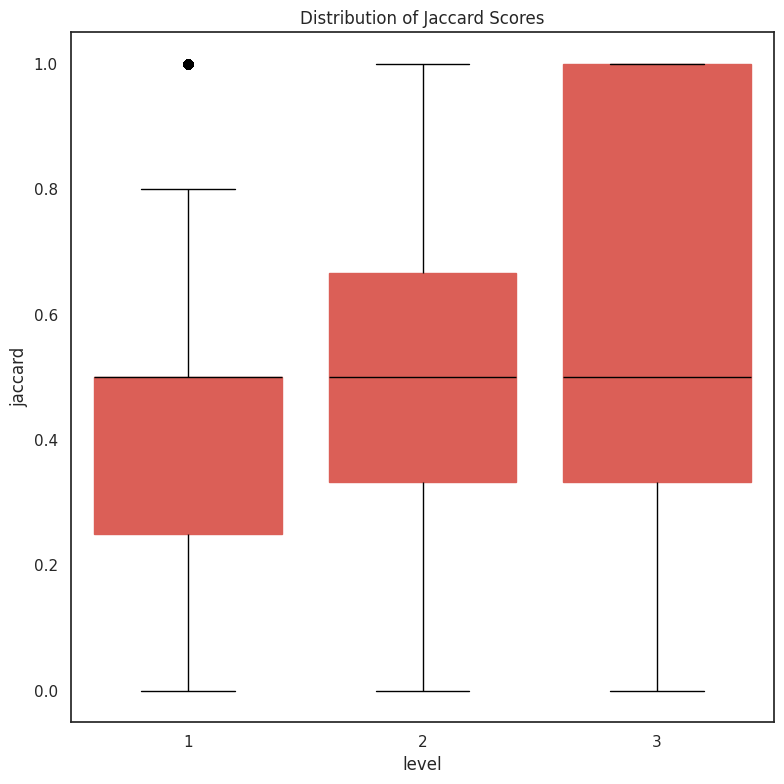

In [19]:
jaccard_distr = jaccard_distr.reshape(-1)
levels = [i for i in [1,2,3] for j in range(len(temp))]
jaccard_df = pd.DataFrame(jaccard_distr, columns=["jaccard"])
jaccard_df["level"] = levels

f, ax = plt.subplots(figsize=(8, 8))
bright_palette = sns.color_palette("hls")
box = sns.boxplot(
    data=jaccard_df, 
    y="jaccard", 
    x="level", 
    ax=ax, 
    boxprops=dict(color=bright_palette[0]),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black"),
    flierprops=dict(markerfacecolor="black", markeredgecolor="black")
)
ax.set_title("Distribution of Jaccard Scores")
plt.tight_layout()

plt.savefig(f"{FIG_DIR}/jacard_box_plots.pdf", dpi=300)
plt.show()

In [20]:
disagreed = temp[temp.same_level3.apply(lambda x: len(x) == 0)]
print(f"{len(disagreed)}/{len(temp)} proteins have no overlap at level 3")

583/5281 proteins have no overlap at level 3


In [21]:
for col in disagreed.columns:
    if "level" in col and ("hpa" in col or "uni" in col):
        disagreed[col] = disagreed[col].apply(lambda x: ";".join(list(x)) if len(x)>0 else pd.NA)

disagreed

/tmp/ipykernel_89854/1965180411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disagreed[col] = disagreed[col].apply(lambda x: ";".join(list(x)) if len(x)>0 else pd.NA)


,uniprot_id,hpa_level1,hpa_level2,hpa_level3,uni_level1,uni_level2,uni_level3,same_level1,hpa_not_uni_level1,uni_not_hpa_level1,replace_level1,same_level2,hpa_not_uni_level2,uni_not_hpa_level2,replace_level2,same_level3,hpa_not_uni_level3,uni_not_hpa_level3,replace_level3
69,A0A096LP01,nucleoplasm;cytosol,cytosol;nucleus,cytosol;nucleus,mitochondria,mitochondria,mitochondria,{},nucleoplasm;cytosol,mitochondria,"[(nucleoplasm, mitochondria), (cytosol, mitoch...",{},cytosol;nucleus,mitochondria,"[(cytosol, mitochondria), (nucleus, mitochondr...",{},cytosol;nucleus,mitochondria,"[(cytosol, mitochondria), (nucleus, mitochondr..."
706,A1A4S6,nucleoplasm;nuclear-membrane;cytosol,cytosol;nucleus,cytosol;nucleus,endosomes,vesicles,endomembrane-system,{},nucleoplasm;nuclear-membrane;cytosol,endosomes,"[(nucleoplasm, endosomes), (nuclear-membrane, ...",{},cytosol;nucleus,vesicles,"[(cytosol, vesicles), (nucleus, vesicles)]",{},cytosol;nucleus,endomembrane-system,"[(cytosol, endomembrane-system), (nucleus, end..."
726,A1KZ92,nucleoplasm;cytosol,cytosol;nucleus,cytosol;nucleus,plasma-membrane;endoplasmic-reticulum,endoplasmic-reticulum;plasma-membrane,plasma-membrane;endomembrane-system,{},nucleoplasm;cytosol,plasma-membrane;endoplasmic-reticulum,"[(nucleoplasm, plasma-membrane), (nucleoplasm,...",{},cytosol;nucleus,endoplasmic-reticulum;plasma-membrane,"[(cytosol, endoplasmic-reticulum), (cytosol, p...",{},cytosol;nucleus,plasma-membrane;endomembrane-system,"[(cytosol, plasma-membrane), (cytosol, endomem..."
916,A4D126,nucleoplasm;nucleoli-fibrillar-center,nucleoli;nucleus,nucleoli;nucleus,cytosol,cytosol,cytosol,{},nucleoplasm;nucleoli-fibrillar-center,cytosol,"[(nucleoplasm, cytosol), (nucleoli-fibrillar-c...",{},nucleoli;nucleus,cytosol,"[(nucleoli, cytosol), (nucleus, cytosol)]",{},nucleoli;nucleus,cytosol,"[(nucleoli, cytosol), (nucleus, cytosol)]"
1010,A6NED2,plasma-membrane;cytosol,plasma-membrane;cytosol,plasma-membrane;cytosol,nucleoplasm,nucleus,nucleus,{},plasma-membrane;cytosol,nucleoplasm,"[(plasma-membrane, nucleoplasm), (cytosol, nuc...",{},plasma-membrane;cytosol,nucleus,"[(plasma-membrane, nucleus), (cytosol, nucleus)]",{},plasma-membrane;cytosol,nucleus,"[(plasma-membrane, nucleus), (cytosol, nucleus)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36018,Q9Y5K8,nucleoplasm;plasma-membrane,plasma-membrane;nucleus,plasma-membrane;nucleus,microtubules;cytosol;centrosome,cytoskeleton;cytosol,cytoskeleton;cytosol,{},nucleoplasm;plasma-membrane,microtubules;cytosol;centrosome,"[(nucleoplasm, microtubules), (nucleoplasm, cy...",{},plasma-membrane;nucleus,cytoskeleton;cytosol,"[(plasma-membrane, cytoskeleton), (plasma-memb...",{},plasma-membrane;nucleus,cytoskeleton;cytosol,"[(plasma-membrane, cytoskeleton), (plasma-memb..."
36029,Q9Y5Q0,nucleoli-fibrillar-center,nucleoli,nucleoli,endoplasmic-reticulum,endoplasmic-reticulum,endomembrane-system,{},nucleoli-fibrillar-center,endoplasmic-reticulum,"[(nucleoli-fibrillar-center, endoplasmic-retic...",{},nucleoli,endoplasmic-reticulum,"[(nucleoli, endoplasmic-reticulum)]",{},nucleoli,endomembrane-system,"[(nucleoli, endomembrane-system)]"
36076,Q9Y616,vesicles,vesicles,endomembrane-system,nucleoplasm;cytosol,cytosol;nucleus,cytosol;nucleus,{},vesicles,nucleoplasm;cytosol,"[(vesicles, nucleoplasm), (vesicles, cytosol)]",{},vesicles,cytosol;nucleus,"[(vesicles, cytosol), (vesicles, nucleus)]",{},endomembrane-system,cytosol;nucleus,"[(endomembrane-system, cytosol), (endomembrane..."
36094,Q9Y673,cytosol,cytosol,cytosol,endoplasmic-reticulum,endoplasmic-reticulum,endomembrane-system,{},cytosol,endoplasmic-reticulum,"[(cytosol, endoplasmic-reticulum)]",{},cytosol,endoplasmic-reticulum,"[(cytosol, endoplasmic-reticulum)]",{},cytosol,endomembrane-system,"[(cytosol, endomembrane-system)]"


In [22]:
disagreed.to_csv(f"{FIG_DIR}/hpa_uniprot_disagreed.csv", index=False)

In [23]:
cols = []
loc_dfs = []
multi_dfs = []
for dataset, df in datasets.items():
    for i in [1,2,3]:
        df_loc = pd.DataFrame(columns=["dataset", "level", "locations", "count", "frequency"])
        df_multi = pd.DataFrame(columns=["dataset", "level", "Num Labels", "count", "frequency"])
        order = mappings[f"level{i}"]
        loc_c, loc_f, multi_c, multi_f = get_counts(disagreed, order, col=f"hpa_level{i}")
        
        df_loc["locations"] = order
        df_loc["count"] = loc_c
        df_loc["frequency"] = loc_f
        df_loc["dataset"] = dataset
        df_loc["level"] = i
        loc_dfs.append(df_loc)

        df_multi["Num Labels"] = [i for i in range(1,9)]
        df_multi["count"] = multi_c
        df_multi["frequency"] =  multi_f
        df_multi["dataset"] = dataset
        df_multi["level"] = i
        multi_dfs.append(df_multi)

loc_df_disagreed_hpa = pd.concat(loc_dfs).reset_index(drop=True)
loc_df_disagreed_hpa = loc_df_disagreed_hpa[(loc_df_disagreed_hpa.dataset=="HPA") & (loc_df_disagreed_hpa.level ==1)]


cols = []
loc_dfs = []
multi_dfs = []
for dataset, df in datasets.items():
    for i in [1,2,3]:
        df_loc = pd.DataFrame(columns=["dataset", "level", "locations", "count", "frequency"])
        df_multi = pd.DataFrame(columns=["dataset", "level", "Num Labels", "count", "frequency"])
        order = mappings[f"level{i}"]
        loc_c, loc_f, multi_c, multi_f = get_counts(disagreed, order, col=f"uni_level{i}")
        
        df_loc["locations"] = order
        df_loc["count"] = loc_c
        df_loc["frequency"] = loc_f
        df_loc["dataset"] = dataset
        df_loc["level"] = i
        loc_dfs.append(df_loc)

        df_multi["Num Labels"] = [i for i in range(1,9)]
        df_multi["count"] = multi_c
        df_multi["frequency"] =  multi_f
        df_multi["dataset"] = dataset
        df_multi["level"] = i
        multi_dfs.append(df_multi)

loc_df_disagreed_uni = pd.concat(loc_dfs).reset_index(drop=True)
loc_df_disagreed_uni = loc_df_disagreed_uni[(loc_df_disagreed_uni.dataset=="UniProt") & (loc_df_disagreed_uni.level ==1)]

<Axes: xlabel='frequency', ylabel='locations'>

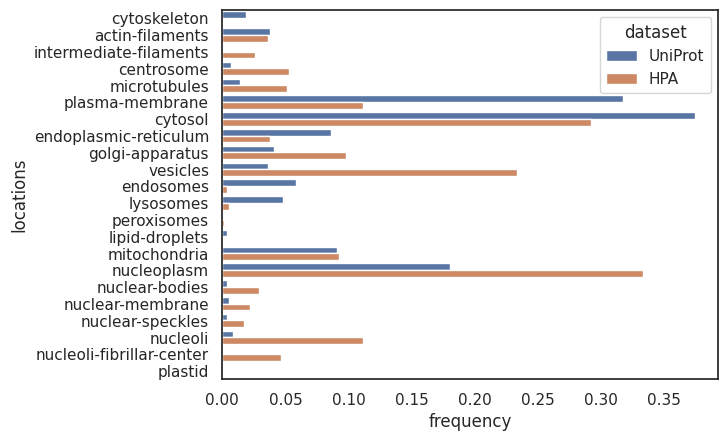

In [24]:
tempdisagree = pd.concat([loc_df_disagreed_uni,loc_df_disagreed_hpa])

sns.barplot(data=tempdisagree, x="frequency", y="locations", hue="dataset")

/tmp/ipykernel_89854/2218880987.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar


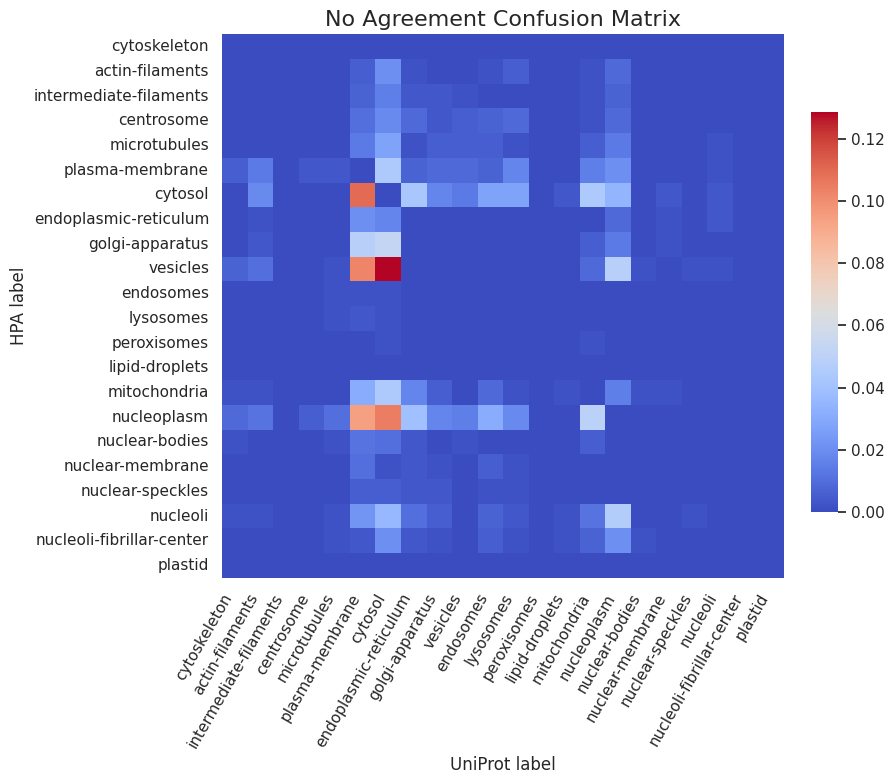

In [25]:
order = mappings[f"level1"]
replacement_counter = np.zeros((len(order), len(order)))
for row in disagreed[f"replace_level1"].to_list():
    for replacement in row:
        hpa_loc, uni_loc = replacement
        j = order.index(hpa_loc)
        k = order.index(uni_loc)
        replacement_counter[j, k] += 1

fig, ax = plt.subplots(figsize=(9, 8))
cbar_ax = fig.add_axes([.91, .35, .03, .5])  # Position for the color bar

#Frequency is over number of disgreed proteins
sns.heatmap(replacement_counter / len(disagreed), xticklabels=order, yticklabels=order, ax=ax, cmap="coolwarm", cbar_ax=cbar_ax)
ax.set_xlabel("UniProt label")
ax.set_ylabel("HPA label")
ax.set_title("No Agreement Confusion Matrix", fontsize=16)  # Set the font size for the title
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

plt.tight_layout(rect=[0, 0, .9, 1])  # Adjust layout to make space for the color bar
plt.savefig(f"{FIG_DIR}/no_agreement_confusion_matrix.pdf", dpi=300)
plt.show()


In [26]:
disagreed[:30]
disagreed.shape

(583, 19)